# neural net to find object center from paper to python

### Learning to optimize a Neural Net, part 1
https://medium.com/@mlrik/learning-to-optimize-a-neural-net-d60e85135b49

This experiment is designed to measure the effects of reinitializing the learned weights of a NN. The Neural Network in this experiment is deliberately small. Also, its search space is known to have (at least) one perfect solution where loss=0.

The task the NN is performing is finding the center of the blob in an image.

<img src="PaperNet.jpg">

This NN has no convolutional layers. The Keras implementation might look like this:
```python
model.add(Dense(4, use_bias=True, activation=None, input_shape=(img_size,)))
model.add(Dense(2, use_bias=True, activation='relu'))
model.add(Dense(1, use_bias=False, activation=None))
```

In the code below, I create multiple versions of this NN. They all have the above architecture, only the initial weights (parameters) are different. Keras initializes the parameters at random using the default algorithm.

## init and import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import keras

%matplotlib inline

/home/paperspace/anaconda3/envs/bletchley/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### a wee warning
This notebook keeps everything in memory. You might run into problems when increasing img_size or sprawl beyond a certain limit.

## create image functions

In [2]:
def make_blob_images(img_size = 3, normx = False, normy = False):
    """create images (X) and labels (Y) indicating center of the object
    each image has an object and some empty space
    images have height of 1 pixel and width of img_size pixels"""
    
    X = []
    Y = []
    if normx:
        pixelvalue = 1
    else:
        pixelvalue = 2*img_size
    #
    for blob_size in range(1, img_size):
        for start in range(0, img_size - blob_size + 1):
            img = [0] * img_size
            img[start:start+blob_size] = [pixelvalue] * blob_size
            center = start + blob_size/2
            if normy:
                center = center / img_size
            X.append(img)
            Y.append(center)
        #
    #
    X = np.array(X)
    Y = np.array(Y)
    Y = Y.reshape(Y.shape[0], 1)
    return X, Y

In [4]:
def plot_img(x,y_true, normy=False):
    """visualize an image (x) with the center of object (y_true) using matplotlib"""
    if normy:
        y_true = y_true * img_size
    img = x.reshape(1,img_size)
    plt.imshow(img, cmap='binary', extent=[0,img_size,0,1])
    plt.plot([y_true,y_true],[0,1], color='r', linewidth=2)
    plt.xticks(np.arange(0,img_size+1))
    plt.yticks([])
    plt.grid(axis='x')
    plt.show()

## create X and Y: images and blob center values
For a given size of the image. Display one such image.

In [139]:
img_size = 3
X,Y = make_blob_images(img_size, normx=True, normy=True)

In [140]:
i=0

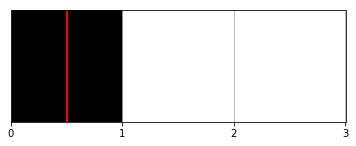

In [141]:
# execute this cell again and again to see more samples of X,Y
x = X[i]
y=Y[i]

plot_img(x,y, normy=True)
i = (i + 1) % len(X) # =0

In [142]:
X.shape

(5, 3)

In [143]:
Y.shape

(5, 1)

In [156]:
print(np.mean(Y))
print(np.std(Y))
print(np.std(Y) ** 2)

0.5
0.23570226039551587
0.055555555555555566


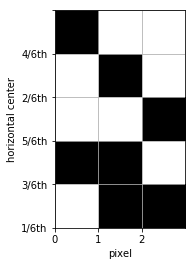

In [145]:
# plot all images in one plot
w = len(X[0])
h = len(X)
nominator = w * 2
nom = "{}th".format(nominator)
enums = []
for i in (Y*nominator).astype(int):
    enums.append("{}/{}".format(i[0], nom))
#

# plt.figure(figsize=(w/2,h/2))
plt.imshow(X, cmap='binary', extent=[0,w,0,h])
plt.grid(axis='both')

plt.xticks(np.arange(0,w),)
plt.yticks(np.arange(0,h+1), enums) # TODO hardcoded values into vars
plt.xlabel("pixel")
plt.ylabel("horizontal center")
plt.show()

## create functions for model handling

In [146]:
def make_model(img_size=3):
    """
    create a NN model according to the PaperNet architecture
    input_shape depends on img_size
    output_shape is 1
    """
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(4, use_bias=True, activation=None , input_shape=(img_size,) ) )
    model.add(keras.layers.Dense(2, use_bias=True, activation='relu' ) )
    model.add(keras.layers.Dense(1, use_bias=False, activation=None ) )
    model = compile_model(model)
    return model

In [147]:
def clone_model(parent):
    """returns exact, compiled, copy of model with weights and all"""
    model = keras.models.clone_model(parent)
    W = parent.get_weights()
    model.set_weights(W)
    model = compile_model(model)
    return model

In [158]:
def compile_model(model):
    """
    returns compiled PaperNet model with SGD optimizer and hard coded hyperparameters
    loss is defined as MAE (mean absolute error)
    """
    model.compile(optimizer=keras.optimizers.SGD(lr=.01), loss=keras.losses.mean_absolute_error, metrics=['mean_absolute_percentage_error'])
    return model

In [159]:
def train(model, epochs = 100):
    """
    trains model using batch_size=len(X)
    returns training history object
    """
    history = model.fit(x=X, y=Y, epochs=epochs, batch_size=len(X), verbose=False)
    return history

In [160]:
def evaluate(model):
    """evaluates model, returns loss and metrics"""
    return model.evaluate(x=X, y=Y, verbose=False)

In [161]:
def waxon_waxoff(parent=None, sprawl=1, epochs=100): 
    """
    creates sprawl number of models, each with different random weights
    if parent model is given, will clone_model(parent) instead, resulting in sprawl identical models
    each model is trained a given number of epochs
    returns three lists with corresponding index: 
    children (contains model objects),
    stats (contains loss values),
    curves (contains history objects)
    """
    children = []
    stats = []
    curves = []
    
    print("train {} models, train each model for {} epochs".format(sprawl, epochs))
    for r in range(sprawl):
        print(" model:", r)
        if parent == None:
            model = make_model(img_size=img_size)
        else:
            model = clone_model(model)
        #
        history = train(model=model, epochs = epochs)
        loss = evaluate(model=model)[0]

        children.append(model)
        stats.append(loss)
        curves.append(history)
    #
    return children, stats, curves


## compare PaperNet theory with PaperNet on gradient descent

In [152]:
## execute some runs with given number of epochs
sprawl = 20
epochs = 200

# start a population of models
generation0, stats0, curves0 = waxon_waxoff(sprawl = sprawl, epochs=epochs)
best0  = np.argmin(stats0)
worst0 = np.argmax(stats0)


train 20 models, train each model for 200 epochs
 model: 0
 model: 1
 model: 2
 model: 3
 model: 4
 model: 5
 model: 6
 model: 7
 model: 8
 model: 9
 model: 10
 model: 11
 model: 12
 model: 13
 model: 14
 model: 15
 model: 16
 model: 17
 model: 18
 model: 19
  mean loss: 0.2777  std dev loss: 0.1763
  best loss: 0.0569    worst loss: 0.5029
  best model: 2      worst model: 13


In [180]:
curves = curves0
generation = generation0
stats = stats0
best = best0
worst = worst0

print("  mean loss: {:.4f}  std dev loss: {:.4f}".format(np.mean(stats), np.std(stats)) )
print("  best loss: {:.4f}    worst loss: {:.4f}".format(min(stats), max(stats)) )
print("  best model: {}      worst model: {}".format(best, worst))

  mean loss: 0.2777  std dev loss: 0.1763
  best loss: 0.0569    worst loss: 0.5029
  best model: 2      worst model: 13


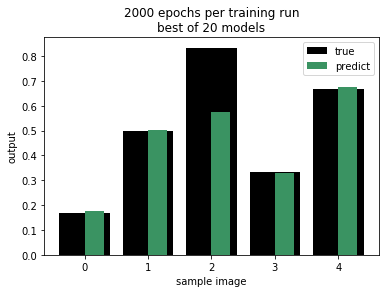

In [181]:
# plot predictions by Best model
model = generation[best]
y_hat = model.predict(x=X).flatten()
pos = range(len(Y.flatten()))
plt.bar(pos, Y.flatten(), -.8, align='center', color='black', label='true')
plt.bar(pos, y_hat, .3, align='edge', color='#3a9362', label='predict')
plt.title("{} epochs per training run\nbest of {} models".format(epochs, sprawl))
plt.xlabel("sample image")
plt.ylabel("output")
plt.legend()
plt.show()

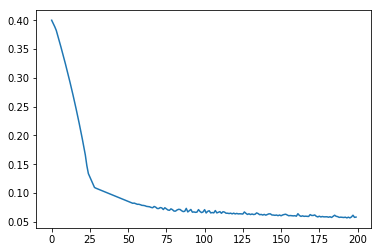

In [182]:
plt.plot(curves[best].history['loss'])
plt.show()

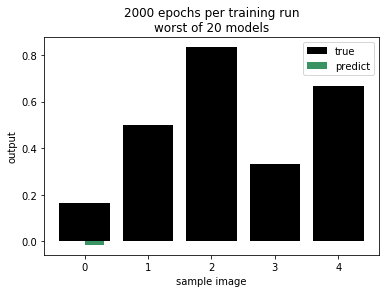

In [183]:
# plot predictions by Worst model
model = generation[worst]
y_hat = model.predict(x=X).flatten()
pos = range(len(Y.flatten()))
plt.bar(pos, Y.flatten(), -.8, align='center', color='black', label='true')
plt.bar(pos, y_hat, .3, align='edge', color='#3a9362', label='predict')
plt.title("{} epochs per training run\nworst of {} models".format(epochs, sprawl))
plt.xlabel("sample image")
plt.ylabel("output")
plt.legend()
plt.show()

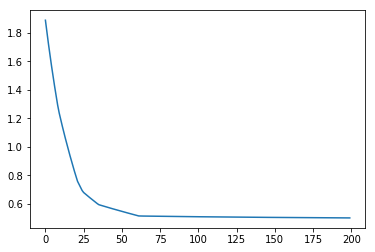

In [184]:
plt.plot(curves[worst].history['loss'])
plt.show()

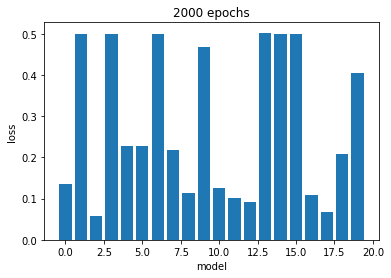

In [185]:
# plot all losses for one population of models
pos = range(len(stats))
plt.bar(pos,stats)
plt.title("{} epochs".format(epochs))
plt.xlabel("model")
plt.ylabel("loss")
plt.show()

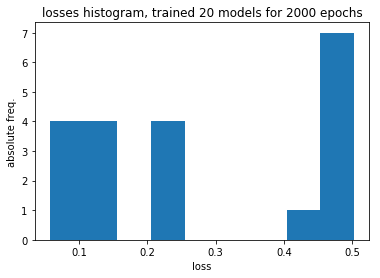

In [186]:
# plot histogram of losses of all models in the generation
plt.hist(x=stats, bins=9)
plt.title("losses histogram, trained {} models for {} epochs".format(sprawl, epochs))
plt.xlabel("loss")
plt.ylabel("absolute freq.")
plt.show()

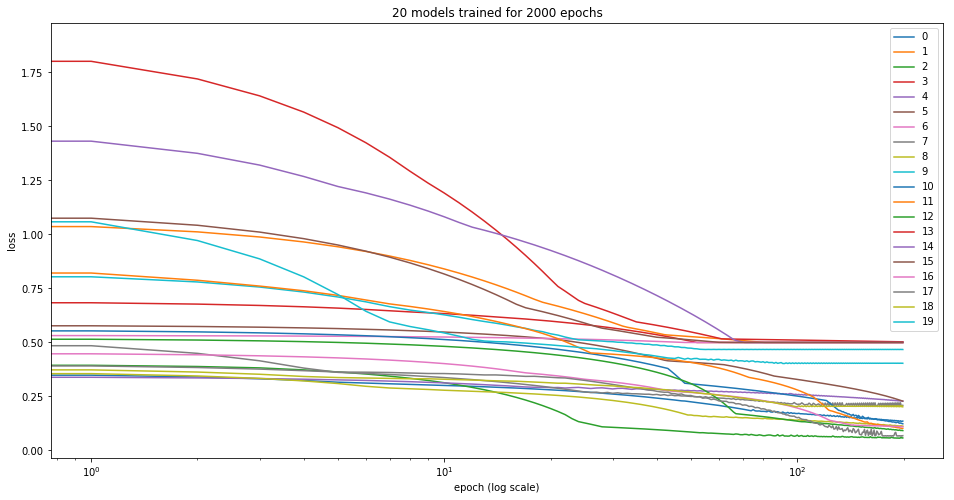

In [187]:
# plot learning curves for all models in one graph
nicknames = range(len(curves))
plt.figure(figsize=(16,8))

for c in nicknames:
    h = curves[c].history['loss']
    plt.plot(h, label=c)
    plt.xscale("log")
#     plt.yscale("log")
plt.title("{} models trained for {} epochs".format(sprawl, epochs))
plt.legend()
plt.xlabel("epoch (log scale)")
plt.ylabel("loss")
plt.show()

### train with more and more epochs

In [176]:
## execute some runs with more epochs
sprawl = 20
epochs = 2000

generation1, stats1, curves1 = waxon_waxoff(sprawl = sprawl, epochs=epochs)
best1  = np.argmin(stats1)
worst1 = np.argmax(stats1)

train 20 models, train each model for 2000 epochs
 model: 0
 model: 1
 model: 2
 model: 3
 model: 4
 model: 5
 model: 6
 model: 7
 model: 8
 model: 9
 model: 10
 model: 11
 model: 12
 model: 13
 model: 14
 model: 15
 model: 16
 model: 17
 model: 18
 model: 19


In [188]:
curves = curves1
generation = generation1
stats = stats1
best = best1
worst = worst1

print("  mean loss: {:.4f}  std dev loss: {:.4f}".format(np.mean(stats), np.std(stats)) )
print("  best loss: {:.4f}    worst loss: {:.4f}".format(min(stats), max(stats)) )
print("  best model: {}      worst model: {}".format(best, worst))

  mean loss: 0.1846  std dev loss: 0.1939
  best loss: 0.0014    worst loss: 0.5000
  best model: 16      worst model: 6


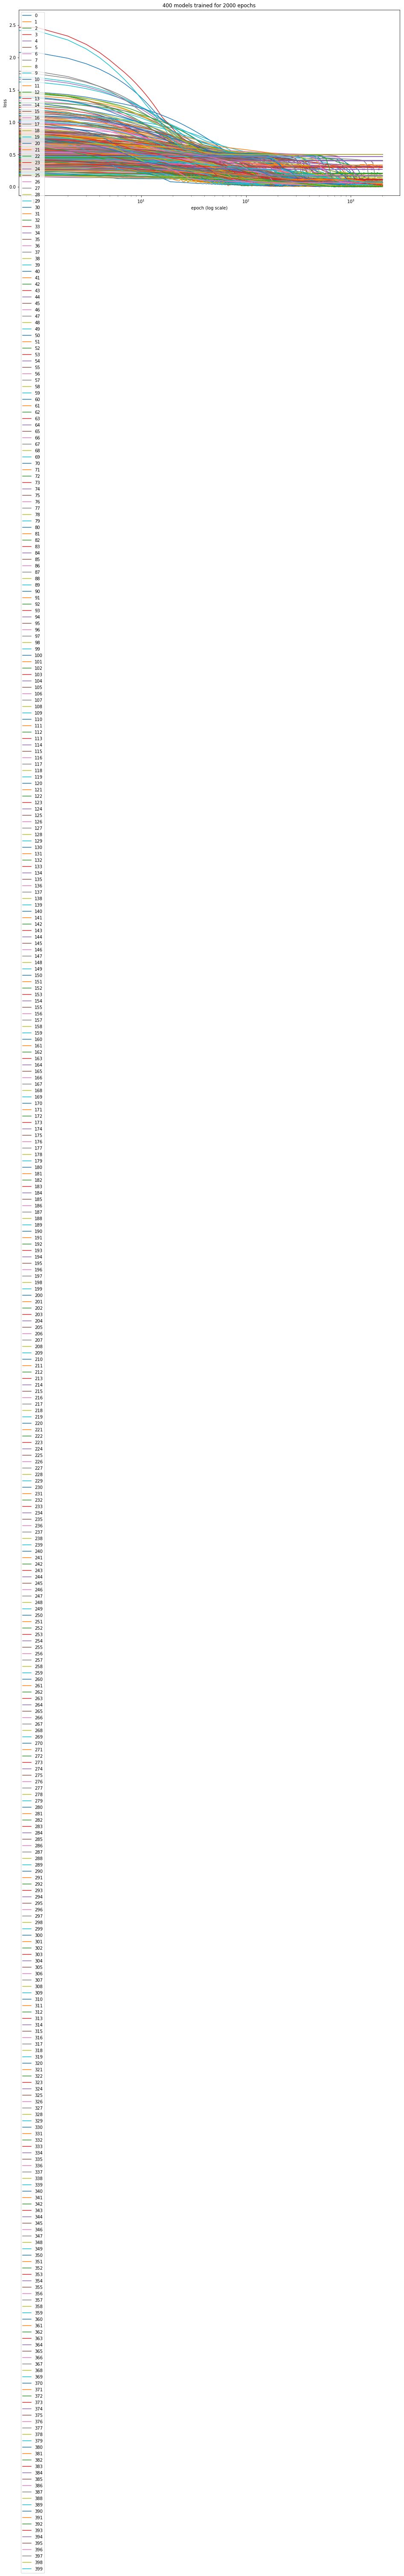

In [198]:
# plot learning curves for all models in one graph
nicknames = range(len(curves))
plt.figure(figsize=(16,8))

for c in nicknames:
    h = curves[c].history['loss']
    plt.plot(h, label=c)
    plt.xscale("log")
#     plt.yscale("log")
plt.title("{} models trained for {} epochs".format(sprawl, epochs))
plt.legend()
plt.xlabel("epoch (log scale)")
plt.ylabel("loss")
plt.show()

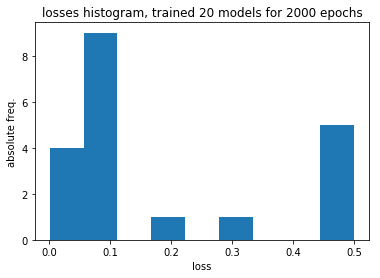

In [189]:
# plot histogram of losses of all models in the generation
plt.hist(x=stats, bins=9)
plt.title("losses histogram, trained {} models for {} epochs".format(sprawl, epochs))
plt.xlabel("loss")
plt.ylabel("absolute freq.")
plt.show()

In [190]:
## execute some runs with even more epochs
# this might take 30 minutes or longer to run
sprawl = 20
epochs = 20000

generation2, stats2, curves2 = waxon_waxoff(sprawl = sprawl, epochs=epochs)
best2  = np.argmin(stats2)
worst2 = np.argmax(stats2)

train 20 models, train each model for 20000 epochs
 model: 0
 model: 1
 model: 2
 model: 3
 model: 4
 model: 5
 model: 6
 model: 7
 model: 8
 model: 9
 model: 10
 model: 11
 model: 12
 model: 13
 model: 14
 model: 15
 model: 16
 model: 17
 model: 18
 model: 19


In [191]:
curves = curves2
generation = generation2
stats = stats2
best = best2
worst = worst2

print("  mean loss: {:.4f}  std dev loss: {:.4f}".format(np.mean(stats), np.std(stats)) )
print("  best loss: {:.4f}    worst loss: {:.4f}".format(min(stats), max(stats)) )
print("  best model: {}      worst model: {}".format(best, worst))

  mean loss: 0.1789  std dev loss: 0.1905
  best loss: 0.0027    worst loss: 0.5000
  best model: 14      worst model: 1


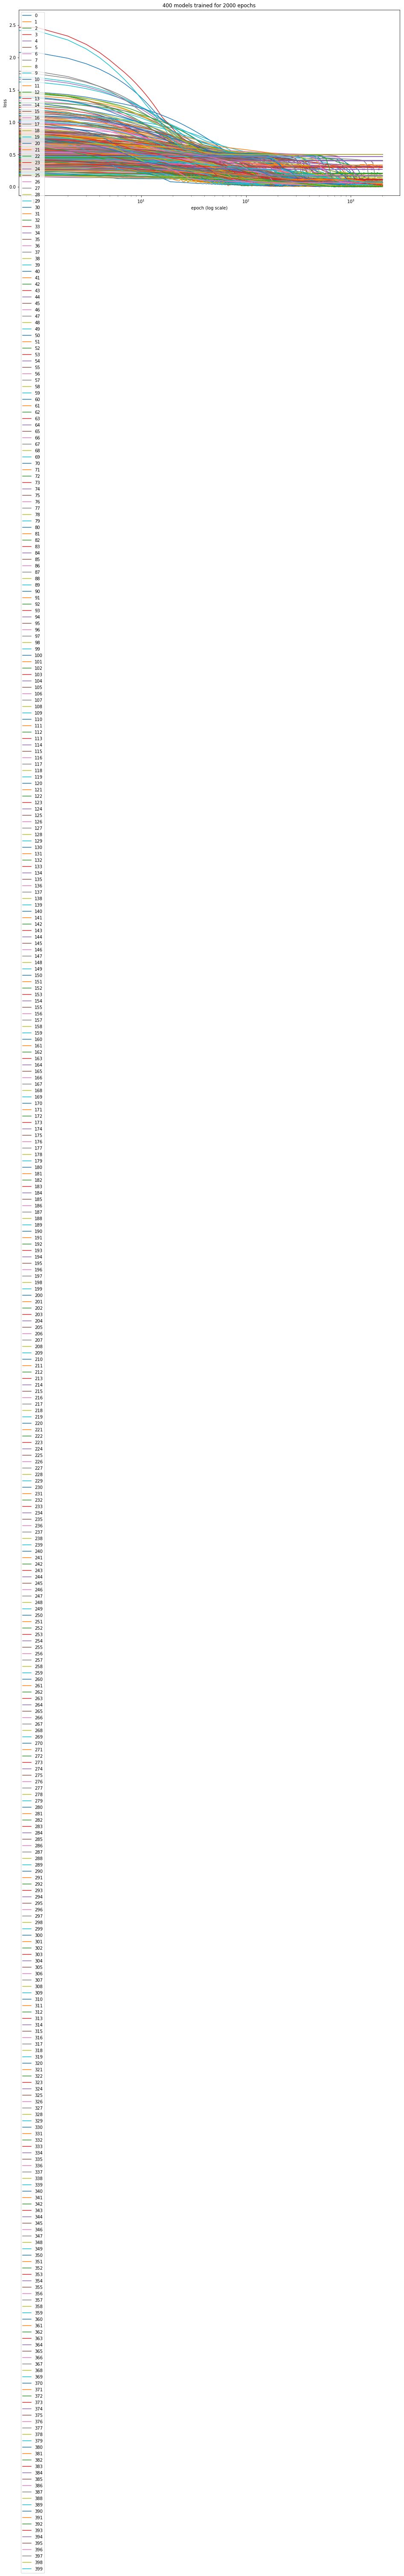

In [199]:
# plot learning curves for all models in one graph
nicknames = range(len(curves))
plt.figure(figsize=(16,8))

for c in nicknames:
    h = curves[c].history['loss']
    plt.plot(h, label=c)
    plt.xscale("log")
#     plt.yscale("log")
plt.title("{} models trained for {} epochs".format(sprawl, epochs))
plt.legend()
plt.xlabel("epoch (log scale)")
plt.ylabel("loss")
plt.show()

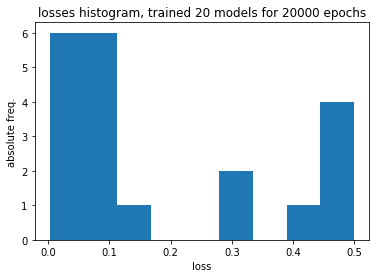

In [192]:
# plot histogram of losses of all models in the generation
plt.hist(x=stats, bins=9)
plt.title("losses histogram, trained {} models for {} epochs".format(sprawl, epochs))
plt.xlabel("loss")
plt.ylabel("absolute freq.")
plt.show()

### train a lot of models for a fair amount of epochs
"a lot": about 400 models

"fair amount": about 2000 epochs

The goal is to observe how many randomly initialized models will train in vain (loss>0.45)

In [193]:
# this too will take a while..
sprawl = 400
epochs = 2000

generation3, stats3, curves3 = waxon_waxoff(sprawl = sprawl, epochs=epochs)
best3  = np.argmin(stats3)
worst3 = np.argmax(stats3)

train 400 models, train each model for 2000 epochs
 model: 0
 model: 1
 model: 2
 model: 3
 model: 4
 model: 5
 model: 6
 model: 7
 model: 8
 model: 9
 model: 10
 model: 11
 model: 12
 model: 13
 model: 14
 model: 15
 model: 16
 model: 17
 model: 18
 model: 19
 model: 20
 model: 21
 model: 22
 model: 23
 model: 24
 model: 25
 model: 26
 model: 27
 model: 28
 model: 29
 model: 30
 model: 31
 model: 32
 model: 33
 model: 34
 model: 35
 model: 36
 model: 37
 model: 38
 model: 39
 model: 40
 model: 41
 model: 42
 model: 43
 model: 44
 model: 45
 model: 46
 model: 47
 model: 48
 model: 49
 model: 50
 model: 51
 model: 52
 model: 53
 model: 54
 model: 55
 model: 56
 model: 57
 model: 58
 model: 59
 model: 60
 model: 61
 model: 62
 model: 63
 model: 64
 model: 65
 model: 66
 model: 67
 model: 68
 model: 69
 model: 70
 model: 71
 model: 72
 model: 73
 model: 74
 model: 75
 model: 76
 model: 77
 model: 78
 model: 79
 model: 80
 model: 81
 model: 82
 model: 83
 model: 84
 model: 85
 model: 86
 m

In [194]:
curves = curves3
generation = generation3
stats = stats3
best = best3
worst = worst3

print("  mean loss: {:.4f}  std dev loss: {:.4f}".format(np.mean(stats), np.std(stats)) )
print("  best loss: {:.4f}    worst loss: {:.4f}".format(min(stats), max(stats)) )
print("  best model: {}      worst model: {}".format(best, worst))

  mean loss: 0.2006  std dev loss: 0.2034
  best loss: 0.0024    worst loss: 0.5000
  best model: 185      worst model: 0


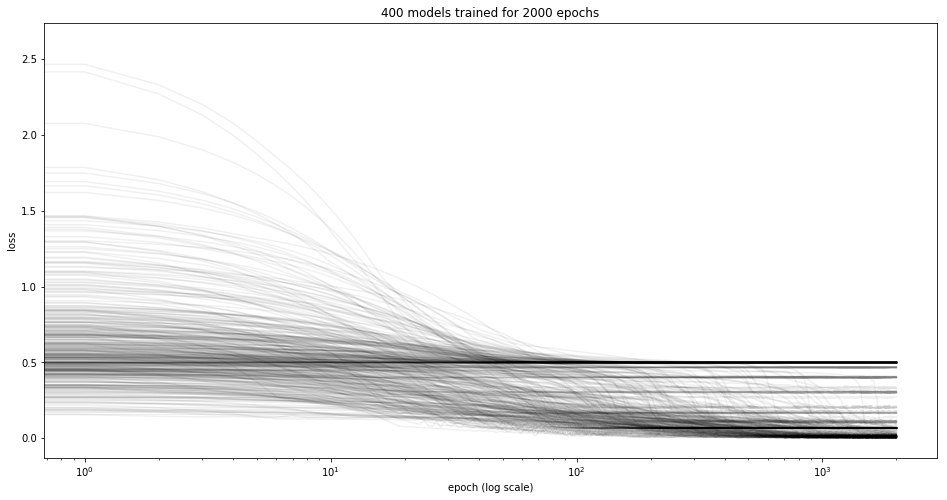

In [195]:
# plot learning curves for all models in one graph
# omit legend, remove color, make gray transparent
nicknames = range(len(curves))
plt.figure(figsize=(16,8))

for c in nicknames:
    h = curves[c].history['loss']
    plt.plot(h, label=c, color='black',alpha=.06)
    plt.xscale("log")
#     plt.yscale("log")
plt.title("{} models trained for {} epochs".format(sprawl, epochs))
# plt.legend()
plt.xlabel("epoch (log scale)")
plt.ylabel("loss")
plt.show()

In [196]:
np.histogram(stats, bins=9)

(array([ 91, 154,   9,   7,   1,  10,   2,  11, 115]),
 array([0.00237815, 0.05766947, 0.11296079, 0.1682521 , 0.22354342,
        0.27883474, 0.33412605, 0.38941737, 0.44470868, 0.5       ]))

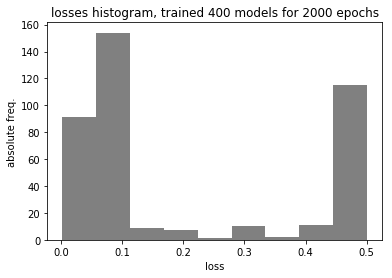

In [197]:
# plot histogram of losses of all models in the generation
plt.hist(x=stats, bins=9, color='gray')
plt.title("losses histogram, trained {} models for {} epochs".format(sprawl, epochs))
plt.xlabel("loss")
plt.ylabel("absolute freq.")
plt.show()

In [ ]:
print(len(np.where(stats > 0.45) ) + 1 )
b = stats > 0.45
print(stats[b].sum())

## take a look at the activations inside a model

In [ ]:
# create three models with decreasing number of layers
model3 = generation[best]
W = model3.get_weights()

model2 = keras.models.clone_model(model3)
model2.set_weights(W)
model2.pop()

model1 = keras.models.clone_model(model3)
model1.set_weights(W)
model1.pop()
model1.pop()

In [ ]:
pred1 = model1.predict(x=X)
print(pred1)
plt.imshow(pred1, cmap='RdBu')
plt.show()

In [ ]:
pred2 = model2.predict(x=X)
print(pred2)
plt.imshow(pred2, cmap='RdBu')
plt.show()

In [ ]:
pred3 = model3.predict(x=X)
# print(pred3)
print((pred3 * 6 + .5).astype(int))

plt.imshow(pred3, cmap='RdBu')
plt.show()